In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
from collections import deque
from math import isclose
import random
import pickle
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

In [2]:
env = gp.Env(empty=True)
# env.setParam("Threads", 16)
env.setParam("OutputFlag",0) # suppress gurobi console output
env.start()

def run_experiments(input_file, lambda_mul):
    print(f'Running the algorithm for lambda = {lambda_mul}')
    lambda_ = lambda_mul * sum(w.values()) / n
    
    # Create a new model
    m = gp.Model("quadratic", env=env)
    m.Params.timeLimit = 120
    m.Params.NonConvex = 2

    # Create variables
    X = dict()
    Y = dict()
    for u in nodes:
        for p in projects:
            X[(u, p)] = m.addVar(vtype=GRB.BINARY, name=f"X({u},{p})")

    for p in projects:
        Y[p] = m.addVar(vtype=GRB.BINARY, name=f"Y_{p})")


    # Linear (project preference) term
    threshold = (numOfUniqueProjects - 3 + 1) / numOfUniqueProjects
    F1 = gp.LinExpr()
    for u in nodes:
        for p in projects:
            if (u, p) in c:
                if penalize and c[(u, p)] < threshold:
                    F1 -= 1000 * X[(u, p)]
                else:
                    F1 += c[(u, p)] * X[(u, p)]
    F1 *= lambda_

    # max-cut term
    F3 = dict()
    F2 = gp.QuadExpr()
    for e in edges:
        u = e[0]; v = e[1]
        F3[e] = gp.QuadExpr()
        for p in projects:
            F3[e] -=  X[(u, p)] * X[(v, p)]
        F3[e] += 1
        F3[e] *= w[(u, v)]
    for e in edges:
        F2 += F3[e]

    F = gp.QuadExpr()
    F = F1 + F2
    m.setObjective(F, GRB.MAXIMIZE)

    # Add constraints

    # Each student assigned to exactly one project
    for u in nodes:
        expr = gp.QuadExpr()
        expr = sum([Y[p] * X[(u, p)] for p in projects])
        m.addConstr(expr == 1)
        expr = sum([X[(u, p)] for p in projects])
        m.addConstr(expr == 1)

    # Project capacity constraints
    for p in projects:
        expr = gp.QuadExpr()
        expr = Y[p] * sum([X[(u, p)] for u in nodes])
        m.addConstr(expr <= capacities[p])
        m.addConstr(expr >= min_capacities[p] * Y[p])
        expr = sum([X[(u, p)] for u in nodes])
        m.addConstr(expr <= capacities[p])
        
    #At least 1 from each project
    expr = gp.LinExpr()
    expr = sum([Y[p+'A'] for p in uniqueProjects])
    m.addConstr(expr >= len(uniqueProjects))
    
    # Each "active" project should have a representative
    expr = gp.QuadExpr()
    for p in projects:
        expr = sum([representatives[u] * Y[p] * X[(u, p)] for u in nodes])
        m.addConstr(expr >= Y[p])
        
    start = time()
    # Optimize model
    m.optimize()

    # Convert solution to dictionary format
    x = dict()
    for u in nodes:
        for p in projects:
            x[(u, p)] = X[(u, p)].X
            
    return x

In [3]:
def construct_teams(x):
    teams = dict()
    for p in projects:
        teams[p] = []

    for e in x:
        u, p = e
        if isclose(x[e], 1):
            u, p = e
            teams[p].append(u)
            
    for p in projects:
        teams[p].sort()
        
    return teams
    
def min_friends(teams):
    minFriends = n
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            minFriends = min(friends, minFriends)
    return minFriends
            
def max_friends(teams):
    maxFriends = 0
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            maxFriends = max(friends, maxFriends)
    return maxFriends

def avg_friends(teams):
    friends = 0
    for team in teams.values():
        friends += sum([1 for u in team for v in team if u != v and (u, v) not in w and (v, u) not in w])
    return friends / n

def reverse_pref(pref):
#     return numOfUniqueProjects - pref + 1 
    return numOfUniqueProjects - pref*numOfUniqueProjects + 1

def min_preference(teams):
    ans = 1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = min(ans, reverse_pref(c[(u, t)]))      
    return ans
            
def max_preference(teams):
    ans = -1
    for t in teams:
        team = teams[t]
        for u in team:
            ans = max(ans, reverse_pref(c[(u, t)]))      
    return ans

def avg_preference(teams):
    pref = 0
    for t in teams:
        team = teams[t]
        pref += sum([reverse_pref(c[(u, t)]) for u in team])
    return pref / n

def friends_distribution(teams):
    dist = deque()
    for team in teams.values():
        for u in team:
            friends = sum([1 for v in team if u != v and (u, v) not in w and (v, u) not in w])
            dist.append(friends)
    return dist

def find_friends(student, teams):
    if student not in nodes:
        return "Not a valid student"
    friends = []
    for team in teams.values():
        for u in team:
            if u == student:
                friends = [v for v in team if u != v and (u, v) not in w and (v, u) not in w]
                return friends
    return []

def find_preference(student, teams):
    if student not in nodes:
        return "Not a valid student"
    for t in teams:
        team = teams[t]
        for u in team:
            if u == student:
                return reverse_pref(c[(u, t)])
    return "find_preference error"

def project_distribution(teams):
    dist = deque()
    for t in teams:
        team = teams[t]
        for u in team:
            dist.append(reverse_pref(c[(u, t)]))
    return dist

def group_keys_by_value(input_dict):
    grouped_dict = {}
    
    for key, value in input_dict.items():
        if value in grouped_dict:
            grouped_dict[value].append(key)
        else:
            grouped_dict[value] = [key]
    
    return grouped_dict

def draw_graph_with_teams(teams, pos, title):
    activeTeams = [t for t in teams if teams[t]]
#     colors = sns.color_palette("tab10", len(activeTeams))
    colors = cm.rainbow(np.linspace(0, 1, len(activeTeams)))
    colors_dict = dict(zip(sorted(activeTeams), colors))

    color_map = []
    for node in G:
        for team in teams:
            if node in teams[team]:
                color_map.append(colors_dict[team])
                break

    nx.draw(G_c, node_color=color_map, pos=pos, with_labels=True)
    plt.title(title)
#     legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color, markeredgecolor=color) for color, label in zip(colors, colors_dict.keys())]
#     plt.legend(handles=legend_handles)
    plt.show()

In [4]:
def analysis(x):
    # ==== Friends graph =====
    print(f'# students = {len(nodes)}')
    
#     nx.draw(G_c, pos=nx.spring_layout(G_c, k=0.2, iterations=20), with_labels=True)
    
    # ==== Construct the team =====
    teams = construct_teams(x)
    activeTeams = [t for t in teams if teams[t]]
    print(f'# active teams = {len(activeTeams)}')
    print("Teams: ")
    for t in activeTeams:
        print(f'team {t}: {teams[t]}')
    
    # ==== Solution statistics ====
    print(f'(optimal assignment) avg number of friends {avg_friends(teams)}')
    print(f'(optimal assignment) min number of friends {min_friends(teams)}')
    print(f'(optimal assignment) max number of friends {max_friends(teams)}')

    print(f'(optimal assignment) avg preference {avg_preference(teams)}')
    print(f'(optimal assignment) min preference {min_preference(teams)}')
    print(f'(optimal assignment) max preference {max_preference(teams)}')

    # ==== Per student analysis ====
    print('===== Per student analysis =====')
    print('student {id}: {project_preference}, {friends}')
    for u in nodes:
        opt_pref = find_preference(u, teams)
        opt_friends = find_friends(u, teams)
        print(f"student {u}: {opt_pref}, {opt_friends}{', representative' if representatives[u] else ''}")

    # ===== Draw graph =====
    draw_graph_with_teams(teams, pos, 'Friends and team assignment')


In [5]:
input_file = 'cs701_LinNorm.pickle'
lambda_mul = 1
numOfUniqueProjects = 8 # num of unique projects

# Read graph
with open(input_file, 'rb') as file:
    projects = pickle.load(file)
    capacities = pickle.load(file)
    numOfProjects = len(capacities)
    c = pickle.load(file)
    w = pickle.load(file)
    edges = pickle.load(file)
    representatives = pickle.load(file)
    
    G = nx.Graph()
    G.add_edges_from(edges)
    G_c = nx.complement(G) # friends graph
    pos=nx.spring_layout(G_c, k=0.2, iterations=20)
    nodes = list(G.nodes)
    n = len(nodes)
#     P = 6 # max number of "active" teams for each project
#     Q = 3 # min number of "active" teams for each project
    min_capacities = dict()
    for p in projects:
        min_capacities[p] = 4

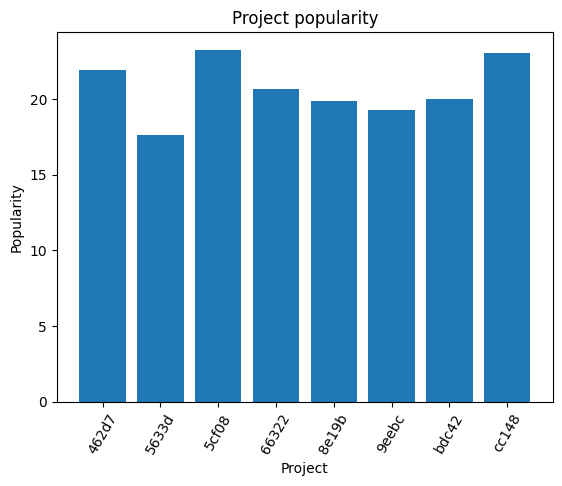

In [6]:
proj_popularity = dict()
uniqueProjects = [p[:-1] for p in projects if p[-1] == 'A']
for p in uniqueProjects:
    proj_popularity[p] = 0
    
for u in nodes:
    for p in projects:
        if (u, p) in c and p[-1] == 'A':
            proj_popularity[p[:-1]] += c[(u, p)]
            
xs = uniqueProjects
ys = proj_popularity.values()

plt.bar(xs, ys)
plt.xlabel('Project')
plt.xticks(rotation = 60)
plt.ylabel('Popularity')
plt.title(f'Project popularity')

plt.show()

Running the algorithm for lambda = 0.2
# students = 37
# active teams = 9
Teams: 
team 462d7A: ['00282', '1f5e5', '36dac', 'ca09b', 'f69a6']
team 5633dA: ['489ac', '534d3', '95cc3', 'f6b90']
team 5cf08A: ['1551f', '1679b', '823dd', 'f1fe2']
team 5cf08B: ['3720a', 'c1c97', 'd24a7', 'f7c1c']
team 66322A: ['31fc3', '5f0ea', 'c023c', 'ea47a']
team 8e19bA: ['425ae', '47e0f', '63877', 'f9c03']
team 9eebcA: ['62bdf', 'b717f', 'e659c', 'ea420']
team bdc42A: ['b18c2', 'c307b', 'cc54f', 'fcb95']
team cc148A: ['225bd', '66712', '74274', 'fc3ba']
(optimal assignment) avg number of friends 0.7567567567567568
(optimal assignment) min number of friends 0
(optimal assignment) max number of friends 3
(optimal assignment) avg preference 1.4594594594594594
(optimal assignment) min preference 1
(optimal assignment) max preference 3.0
===== Per student analysis =====
student {id}: {project_preference}, {friends}
student c1c97: 2.0, ['3720a', 'd24a7', 'f7c1c']
student f9c03: 2.0, ['47e0f', '63877'], represe

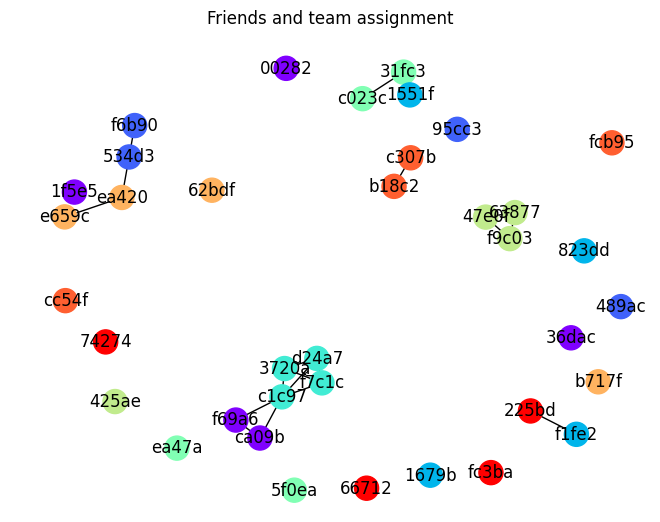

In [7]:
penalize = True
for l in [0.2]:
    lambda_mul = l
    x = run_experiments(input_file, lambda_mul)
    analysis(x)